In [120]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from utils.results_utils import *
from utils.save_results_utils import *
import torch
import torch.nn as nn
import seaborn as sns
import pickle
from multiprocessing import Pool
from matplotlib.patches import Patch
from scipy.stats import linregress, pearsonr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load results

In [121]:
with open('processed_results/mnist_DomainInd_two_variables_no_es_test_results_dict.pkl', 'rb') as f:
    DomainInd_test_results_dict = pickle.load(f)
with open('processed_results/mnist_resampling_two_variables_no_es_test_results_dict.pkl', 'rb') as f:
    resampling_test_results_dict = pickle.load(f)
with open('processed_results/mnist_CFair_two_variables_no_es_test_results_dict.pkl', 'rb') as f:
    cfair_test_results_dict = pickle.load(f)
with open('processed_results/mnist_GroupDRO_two_variables_no_es_train_val_results_dict.pkl', 'rb') as f:
    train_val_dict = pickle.load(f)
with open('processed_results/mnist_GroupDRO_two_variables_no_es_test_results_dict.pkl', 'rb') as f:
    test_results_dict = pickle.load(f)
with open('processed_results/mnist_GroupDRO_two_variables_no_es_loss_dict.pkl', 'rb') as f:
    loss_dict = pickle.load(f)

# reorder dicts
for dictionary in [train_val_dict, test_results_dict, loss_dict]:
    if 'baseline' in dictionary.keys():
        keys_order = ['baseline', 'SY', 'AY'] + [k for k in dictionary if k not in {'baseline', 'SY', 'AY'}]
    else:
        keys_order = ['SY', 'AY'] + [k for k in dictionary if k not in {'SY', 'AY'}]

    reordered_dict = {k: dictionary[k] for k in keys_order}
    dictionary.clear()
    dictionary.update(reordered_dict)

random_seed_folders = ['42','43','44']
loss_fn = nn.BCEWithLogitsLoss()

## Overall test results

gDRO

In [122]:
# get mean and std over 3 random seeds
mean_test_results_dict = {}
for key in test_results_dict.keys():
    mean_test_results_dict[key] = {}
    all_overall_test_results = pd.concat([test_results_dict[key][x]['overall_test_results'].T for x in test_results_dict[key].keys()])
    mean_std = all_overall_test_results.apply(pd.to_numeric).describe().loc[['mean', 'std']]
    mean_test_results_dict[key]['overall_test_results'] = mean_std
overall_results_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['mean'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T
overall_std_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['std'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T

overall_results_df.columns = ['Accuracy','AUC','Precision','Recall']
overall_results_df.round(3) 
overall_std_df.columns = ['Accuracy','AUC','Precision','Recall']

baseline_row = overall_results_df.loc['baseline']
baseline_row_df = baseline_row.to_frame().T
baseline_std_row = overall_std_df.loc['baseline']
baseline_std_row_df = baseline_std_row.to_frame().T

overall_results_df.astype(str) + ' ± ' + overall_std_df.astype(str)


Accuracy            AUC      Precision         Recall
baseline      0.698 ± 0.054  0.792 ± 0.057  0.683 ± 0.031  0.713 ± 0.111
SY             0.69 ± 0.018   0.76 ± 0.021  0.678 ± 0.019   0.702 ± 0.02
AY            0.793 ± 0.001  0.876 ± 0.007  0.782 ± 0.022  0.806 ± 0.042
Artefact      0.678 ± 0.015  0.754 ± 0.016  0.668 ± 0.022  0.689 ± 0.026
AY_8           0.787 ± 0.01  0.874 ± 0.003  0.775 ± 0.026    0.8 ± 0.022
Sex           0.683 ± 0.014  0.756 ± 0.014  0.671 ± 0.023  0.698 ± 0.029
SY_8          0.695 ± 0.015   0.768 ± 0.02  0.692 ± 0.041  0.694 ± 0.076
Y             0.683 ± 0.013  0.752 ± 0.019  0.678 ± 0.021   0.678 ± 0.02
noisy_AY_001  0.789 ± 0.011  0.881 ± 0.007  0.763 ± 0.019  0.827 ± 0.016
noisy_AY_005  0.788 ± 0.009  0.877 ± 0.005  0.782 ± 0.048  0.798 ± 0.062
noisy_AY_010  0.784 ± 0.016   0.87 ± 0.008  0.777 ± 0.029  0.787 ± 0.007
noisy_AY_025  0.775 ± 0.018  0.864 ± 0.011  0.754 ± 0.024  0.806 ± 0.033
noisy_AY_050  0.743 ± 0.009  0.818 ± 0.014  0.751 ± 0.044   0.72 ± 0.066
Random        0.678 ± 0.018  0.748 ± 0.018   0.67 ± 0.026   0.681 ± 0.02
Majority      0.773 ± 0.025  0.865 ± 0.007  0.741 ± 0.041  0.832 ± 0.019
YAS           0.824 ± 0.008   0.906 ± 0.01  0.797 ± 0.021  0.865 ± 0.057

Resampling

In [123]:
mean_test_results_dict = {}
for key in resampling_test_results_dict.keys():
    mean_test_results_dict[key] = {}
    all_overall_test_results = pd.concat([resampling_test_results_dict[key][x]['overall_test_results'].T for x in resampling_test_results_dict[key].keys()])
    mean_std = all_overall_test_results.apply(pd.to_numeric).describe().loc[['mean', 'std']]
    mean_test_results_dict[key]['overall_test_results'] = mean_std
resampling_overall_results_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['mean'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T
resampling_overall_std_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['std'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T

resampling_overall_results_df.columns = ['Accuracy','AUC','Precision','Recall']
resampling_overall_results_df.round(3) 
resampling_overall_std_df.columns = ['Accuracy','AUC','Precision','Recall']

resampling_overall_results_df = pd.concat([baseline_row_df, resampling_overall_results_df], axis=0)
resampling_overall_std_df = pd.concat([baseline_std_row_df, resampling_overall_std_df], axis=0)

resampling_overall_results_df.astype(str) + ' ± ' + resampling_overall_std_df.astype(str)

Accuracy            AUC      Precision         Recall
baseline      0.698 ± 0.054  0.792 ± 0.057  0.683 ± 0.031  0.713 ± 0.111
Artefact      0.676 ± 0.022  0.755 ± 0.024    0.68 ± 0.03  0.643 ± 0.025
AY            0.788 ± 0.033  0.872 ± 0.034  0.787 ± 0.036  0.779 ± 0.043
AY_8          0.779 ± 0.047  0.861 ± 0.057  0.777 ± 0.034   0.77 ± 0.076
Sex           0.674 ± 0.018   0.755 ± 0.01  0.671 ± 0.028  0.663 ± 0.035
SY            0.679 ± 0.021  0.759 ± 0.014  0.679 ± 0.023  0.659 ± 0.038
SY_8          0.669 ± 0.005  0.752 ± 0.004  0.673 ± 0.019   0.637 ± 0.04
Y              0.679 ± 0.02  0.758 ± 0.022  0.679 ± 0.029  0.658 ± 0.025
noisy_AY_001  0.782 ± 0.033  0.865 ± 0.043  0.768 ± 0.036  0.801 ± 0.074
noisy_AY_005  0.802 ± 0.014  0.876 ± 0.019  0.799 ± 0.005  0.796 ± 0.036
noisy_AY_010   0.761 ± 0.02  0.842 ± 0.016  0.749 ± 0.025  0.776 ± 0.076
noisy_AY_025  0.798 ± 0.006  0.881 ± 0.014  0.789 ± 0.031  0.807 ± 0.063
noisy_AY_050  0.768 ± 0.011  0.854 ± 0.009  0.753 ± 0.028  0.789 ± 0.024
Random        0.678 ± 0.011  0.759 ± 0.011  0.688 ± 0.031   0.636 ± 0.04
Majority      0.782 ± 0.019  0.867 ± 0.013  0.795 ± 0.051  0.755 ± 0.029
YAS           0.834 ± 0.016  0.907 ± 0.018  0.802 ± 0.004   0.879 ± 0.04

DomainInd

In [124]:
mean_test_results_dict = {}
for key in DomainInd_test_results_dict.keys():
    mean_test_results_dict[key] = {}
    all_overall_test_results = pd.concat([DomainInd_test_results_dict[key][x]['overall_test_results'].T for x in DomainInd_test_results_dict[key].keys()])
    mean_std = all_overall_test_results.apply(pd.to_numeric).describe().loc[['mean', 'std']]
    mean_test_results_dict[key]['overall_test_results'] = mean_std
DomainInd_overall_results_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['mean'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T
DomainInd_overall_std_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['std'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T

DomainInd_overall_results_df.columns = ['Accuracy','AUC','Precision','Recall']
DomainInd_overall_results_df.round(3) 
DomainInd_overall_std_df.columns = ['Accuracy','AUC','Precision','Recall']

DomainInd_overall_results_df = pd.concat([baseline_row_df, DomainInd_overall_results_df], axis=0)
DomainInd_overall_std_df = pd.concat([baseline_std_row_df, DomainInd_overall_std_df], axis=0)

DomainInd_overall_results_df.astype(str) + ' ± ' + DomainInd_overall_std_df.astype(str)

Accuracy            AUC      Precision         Recall
baseline     0.698 ± 0.054  0.792 ± 0.057  0.683 ± 0.031  0.713 ± 0.111
Artefact      0.73 ± 0.042   0.796 ± 0.04  0.734 ± 0.053   0.71 ± 0.068
A_4          0.654 ± 0.086  0.727 ± 0.088   0.635 ± 0.08  0.693 ± 0.093
Sex          0.639 ± 0.025  0.749 ± 0.011  0.652 ± 0.043  0.577 ± 0.013
S_4             0.6 ± 0.01  0.712 ± 0.003  0.585 ± 0.009  0.635 ± 0.013
AS           0.705 ± 0.057  0.777 ± 0.053  0.688 ± 0.079   0.75 ± 0.067
Random       0.626 ± 0.018  0.702 ± 0.024   0.614 ± 0.02  0.642 ± 0.005
Majority       0.51 ± 0.01  0.508 ± 0.014   0.501 ± 0.01  0.513 ± 0.003
noisy_A_001  0.586 ± 0.046  0.666 ± 0.005  0.593 ± 0.083  0.586 ± 0.096
noisy_A_005  0.594 ± 0.008  0.688 ± 0.006  0.584 ± 0.009   0.609 ± 0.09
noisy_A_010  0.597 ± 0.011  0.687 ± 0.013  0.601 ± 0.025  0.542 ± 0.043
noisy_A_025   0.636 ± 0.03  0.717 ± 0.024  0.629 ± 0.034  0.633 ± 0.028
noisy_A_050   0.647 ± 0.01  0.723 ± 0.013  0.638 ± 0.019  0.654 ± 0.029

CFair

In [125]:
mean_test_results_dict = {}
for key in cfair_test_results_dict.keys():
    mean_test_results_dict[key] = {}
    all_overall_test_results = pd.concat([cfair_test_results_dict[key][x]['overall_test_results'].T for x in cfair_test_results_dict[key].keys()])
    mean_std = all_overall_test_results.apply(pd.to_numeric).describe().loc[['mean', 'std']]
    mean_test_results_dict[key]['overall_test_results'] = mean_std
cfair_overall_results_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['mean'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T
cfair_overall_std_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['std'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T

cfair_overall_results_df.columns = ['Accuracy','AUC','Precision','Recall']
cfair_overall_results_df.round(3) 
cfair_overall_std_df.columns = ['Accuracy','AUC','Precision','Recall']

cfair_overall_results_df = pd.concat([baseline_row_df, cfair_overall_results_df], axis=0)
cfair_overall_std_df = pd.concat([baseline_std_row_df, cfair_overall_std_df], axis=0)

cfair_overall_results_df.astype(str) + ' ± ' + cfair_overall_std_df.astype(str)

Accuracy            AUC      Precision         Recall
baseline     0.698 ± 0.054  0.792 ± 0.057  0.683 ± 0.031  0.713 ± 0.111
Artefact     0.679 ± 0.014   0.75 ± 0.022  0.668 ± 0.027  0.693 ± 0.024
Sex          0.574 ± 0.026  0.649 ± 0.029  0.564 ± 0.032  0.608 ± 0.035
Majority     0.682 ± 0.015  0.751 ± 0.017  0.669 ± 0.024    0.7 ± 0.028
noisy_A_001  0.674 ± 0.016  0.749 ± 0.018  0.673 ± 0.036  0.663 ± 0.045
noisy_A_005  0.675 ± 0.021   0.744 ± 0.02  0.669 ± 0.025  0.672 ± 0.015
noisy_A_010  0.685 ± 0.021   0.753 ± 0.02  0.679 ± 0.022    0.68 ± 0.03
noisy_A_025  0.684 ± 0.021   0.754 ± 0.02  0.688 ± 0.037  0.655 ± 0.016
noisy_A_050  0.685 ± 0.015  0.755 ± 0.017  0.679 ± 0.025  0.681 ± 0.015

Save results

In [126]:
df = pd.concat([overall_results_df['AUC'].astype(str) + ' ± ' + overall_std_df['AUC'].astype(str), resampling_overall_results_df['AUC'].astype(str) + ' ± ' + resampling_overall_std_df['AUC'].astype(str)], axis=1)
df.columns = ['gDRO', 'Resampling']
df.index.name = 'Subgroup'
df.to_csv('processed_results/mnist_overall_auc_gdro_resampling.csv',index=True)

df = pd.concat([DomainInd_overall_results_df['AUC'].astype(str) + ' ± ' + DomainInd_overall_std_df['AUC'].astype(str), cfair_overall_results_df['AUC'].astype(str) + ' ± ' + cfair_overall_std_df['AUC'].astype(str)], axis=1)
df.columns = ['DomainInd', 'CFair']
df.index.name = 'Subgroup'
df.to_csv('processed_results/mnist_overall_auc_domainind_cfair.csv',index=True)

## Baseline performance

In [127]:
best_val_dict = {}
loss_fn = nn.BCEWithLogitsLoss()
auc_list = []
acc_list = []
for random_seed in ['42','43','44']:
    best_loss = 1
    index = 0
    for i in range(len(train_val_dict['baseline'][random_seed]['val_preds'])):
        val_pred_df = train_val_dict['baseline'][random_seed]['val_preds'][i]
        loss = loss_fn(torch.tensor(val_pred_df['raw_pred'].values).float(),torch.tensor(val_pred_df['binary_label'].values).float())
        if loss < best_loss:
            best_loss = loss
            index = i
    best_val_dict[random_seed] = (index,best_loss)
    
    val_pred_df = train_val_dict['baseline'][random_seed]['val_preds'][index]

    auc = roc_auc_score(val_pred_df['binary_label'].values,val_pred_df['raw_pred'].values)
    acc = len(val_pred_df[val_pred_df['pred']==val_pred_df['binary_label']])/len(val_pred_df)

    auc_list.append(auc)
    acc_list.append(acc)

baseline_val_test_auc = pd.DataFrame()
val_auc = [np.mean(auc_list).round(3).astype(str) + ' ± ' + np.std(auc_list).round(3).astype(str)]
test_auc = [overall_results_df.loc['baseline']['AUC'].round(3).astype(str) + ' ± ' + overall_std_df.loc['baseline']['AUC'].round(3).astype(str)]
baseline_val_test_auc['Val AUC'] = val_auc
baseline_val_test_auc['Test AUC'] = test_auc

baseline_val_test_acc = pd.DataFrame()
val_acc = [np.mean(acc_list).round(3).astype(str) + ' ± ' + np.std(acc_list).round(3).astype(str)]
test_acc = [overall_results_df.loc['baseline']['Accuracy'].round(3).astype(str) + ' ± ' + overall_std_df.loc['baseline']['Accuracy'].round(3).astype(str)]
baseline_val_test_acc['Val Accuracy'] = val_acc
baseline_val_test_acc['Test Accuracy'] = test_acc

baseline_val_test_acc

Val Accuracy  Test Accuracy
0  0.943 ± 0.012  0.698 ± 0.054

## Disparities

### S disparities

gDRO

In [153]:
col_name = 'Sex_binary'
experiments = test_results_dict.keys()
experiments = list(experiments)

acc = []
acc_df = pd.DataFrame()
acc_std_df = pd.DataFrame()
n_epochs = 50

for i,exp in enumerate(experiments):
    list_subgroup_results = []
    for random_seed in random_seed_folders:
        test_preds = test_results_dict[exp][random_seed]['test_preds']
        train_acc_list, train_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
        subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_tnr': train_tnr_list[-1]})
        list_subgroup_results.append(subgroup_df)

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    acc_df[exp] = subgroup_mean['test_acc']
    acc_std_df[exp] = subgroup_std['test_acc']

acc_df.index.name = 'S'
baseline_s_test = acc_df['baseline']
baseline_s_test_std = acc_std_df['baseline']

gdro_s_acc_df = acc_df.copy()
gdro_s_acc_std_df = acc_std_df.copy()
gdro_s_acc_df['Method'] = 'gdro'
gdro_s_acc_std_df['Method'] = 'gdro'

In [154]:
# do the same analysis on final val_preds

col_name = 'Sex_binary'
experiments = test_results_dict.keys()
experiments = list(experiments)

acc = []
acc_df = pd.DataFrame()
acc_std_df = pd.DataFrame()
n_epochs = 50

for i,exp in enumerate(experiments):
    list_subgroup_results = []
    for random_seed in random_seed_folders:
        # first need to find whcih epoch had the best val loss
        best_loss = 1
        index = 0
        for i in range(len(train_val_dict[exp][random_seed]['val_preds'])):
            val_pred_df = train_val_dict[exp][random_seed]['val_preds'][i]
            loss = loss_fn(torch.tensor(val_pred_df['raw_pred'].values).float(),torch.tensor(val_pred_df['binary_label'].values).float())
            if loss < best_loss:
                best_loss = loss
                index = i

        test_preds = train_val_dict[exp][random_seed]['val_preds'][index]
        train_acc_list, train_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
        subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_tnr': train_tnr_list[-1]})
        list_subgroup_results.append(subgroup_df)

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    acc_df[exp] = subgroup_mean['test_acc']
    acc_std_df[exp] = subgroup_std['test_acc']

baseline_s_val = acc_df['baseline']
baseline_s_val_std = acc_std_df['baseline']

Resampling

In [155]:
col_name = 'Sex_binary'
experiments = resampling_test_results_dict.keys()
experiments = list(experiments)

acc = []
acc_df = pd.DataFrame()
acc_std_df = pd.DataFrame()
n_epochs = 50

for i,exp in enumerate(experiments):
    list_subgroup_results = []
    for random_seed in random_seed_folders:
        test_preds = resampling_test_results_dict[exp][random_seed]['test_preds']
        train_acc_list, trainx_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
        train_auc_list = get_subgroup_auc([test_preds], col_name)
        subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_tnr': train_tnr_list[-1],'test_auc':train_auc_list[-1]})
        list_subgroup_results.append(subgroup_df)

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    acc_df[exp] = subgroup_mean['test_acc']
    acc_std_df[exp] = subgroup_std['test_acc']

acc_df.index.name = 'S'
acc_df['baseline'] = baseline_s_test
acc_std_df['baseline'] = baseline_s_test_std

resampling_s_acc_df = acc_df.copy()
resampling_s_acc_std_df = acc_std_df.copy()
resampling_s_acc_df['Method'] = 'resampling'
resampling_s_acc_std_df['Method'] = 'resampling'

Merge both

In [156]:
# resampling gDRO mean S disparities
resampling_s_acc_df.drop(columns='Method',inplace=True)
min_values = resampling_s_acc_df.min()
resampling_s_acc_df.loc['min Acc'] = min_values
resampling_s_acc_df.loc['Acc gap'] = abs(resampling_s_acc_df.iloc[0]-resampling_s_acc_df.iloc[1])
resampling_s_acc_df = resampling_s_acc_df.iloc[2:]
gdro_s_acc_df.drop(columns='Method',inplace=True)
min_values = gdro_s_acc_df.min()
gdro_s_acc_df.loc['min Acc'] = min_values
gdro_s_acc_df.loc['Acc gap'] = abs(gdro_s_acc_df.iloc[0]-gdro_s_acc_df.iloc[1])
gdro_s_acc_df = gdro_s_acc_df.iloc[2:]
mnist_gdro_resampling_s_acc_df = pd.concat([gdro_s_acc_df.T,resampling_s_acc_df.T],axis=1)
mnist_gdro_resampling_s_acc_df.to_csv('processed_results/mnist_gdro_resampling_s_acc.csv',index=True)

# resampling gDRO std S disparities
resampling_s_acc_std_df.drop(columns='Method',inplace=True)
min_values = resampling_s_acc_std_df.iloc[0] # min is always s=0 
resampling_s_acc_std_df.loc['min Acc'] = min_values
resampling_s_acc_std_df.loc['Acc gap'] = np.sqrt(resampling_s_acc_std_df.iloc[0]**2+resampling_s_acc_std_df.iloc[1]**2)
resampling_s_acc_std_df = resampling_s_acc_std_df.iloc[2:]
gdro_s_acc_std_df.drop(columns='Method',inplace=True)
min_values = gdro_s_acc_std_df.iloc[0]
gdro_s_acc_std_df.loc['min Acc'] = min_values
gdro_s_acc_std_df.loc['Acc gap'] = abs(gdro_s_acc_std_df.iloc[0]+gdro_s_acc_std_df.iloc[1])
gdro_s_acc_std_df = gdro_s_acc_std_df.iloc[2:]
mnist_gdro_resampling_s_acc_std_df = pd.concat([gdro_s_acc_std_df.T,resampling_s_acc_std_df.T],axis=1)
mnist_gdro_resampling_s_acc_std_df
mnist_gdro_resampling_s_acc_std_df.to_csv('processed_results/mnist_gdro_resampling_s_acc_std.csv',index=True)

### A disparities

gDRO

In [144]:
col_name = 'Artefact'
experiments = test_results_dict.keys()
experiments = list(experiments)

acc = []
acc_df = pd.DataFrame()
acc_std_df = pd.DataFrame()
n_epochs = 50

for i,exp in enumerate(experiments):
    list_subgroup_results = []
    for random_seed in random_seed_folders:
        test_preds = test_results_dict[exp][random_seed]['test_preds']
        #test_preds['pred'] = test_preds['pred_05_threshold']
        #test_preds['pred'] = test_preds['pred_balanced_acc_val_threshold']
        train_acc_list, train_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
        train_auc_list = get_subgroup_auc([test_preds], col_name)
        subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_tnr': train_tnr_list[-1],'test_auc':train_auc_list[-1]})
        list_subgroup_results.append(subgroup_df)

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    acc_df[exp] = subgroup_mean['test_acc']
    acc_std_df[exp] = subgroup_std['test_acc']

acc_df.index.name = 'A'

baseline_a_test = acc_df['baseline']
baseline_a_test_std = acc_std_df['baseline']

gdro_a_acc_df = acc_df.copy()
gdro_a_acc_std_df = acc_std_df.copy()
gdro_a_acc_df['Method'] = 'gdro'
gdro_a_acc_std_df['Method'] = 'gdro'

In [145]:
# on val
acc = []
acc_df = pd.DataFrame()
acc_std_df = pd.DataFrame()
n_epochs = 50

experiments = test_results_dict.keys()
experiments = list(experiments)

for i,exp in enumerate(experiments):
    list_subgroup_results = []
    for random_seed in random_seed_folders:
        best_loss = 1
        index = 0
        for i in range(len(train_val_dict[exp][random_seed]['val_preds'])):
            val_pred_df = train_val_dict[exp][random_seed]['val_preds'][i]
            loss = loss_fn(torch.tensor(val_pred_df['raw_pred'].values).float(),torch.tensor(val_pred_df['binary_label'].values).float())
            if loss < best_loss:
                best_loss = loss
                index = i

        test_preds = train_val_dict[exp][random_seed]['val_preds'][index]
        train_acc_list, train_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
        train_auc_list = get_subgroup_auc([test_preds], col_name)
        subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_tnr': train_tnr_list[-1],'test_auc':train_auc_list[-1]})
        list_subgroup_results.append(subgroup_df)

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    acc_df[exp] = subgroup_mean['test_acc']
    acc_std_df[exp] = subgroup_std['test_acc']

acc_df.index.name = 'A'

baseline_a_val = acc_df['baseline']
baseline_a_val_std = acc_std_df['baseline']

Resampling

In [146]:
col_name = 'Artefact'
experiments = resampling_test_results_dict.keys()
experiments = list(experiments)

acc = []
acc_df = pd.DataFrame()
acc_std_df = pd.DataFrame()
n_epochs = 50

for i,exp in enumerate(experiments):
    list_subgroup_results = []
    for random_seed in random_seed_folders:
        test_preds = resampling_test_results_dict[exp][random_seed]['test_preds']
        train_acc_list, train_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
        train_auc_list = get_subgroup_auc([test_preds], col_name)
        subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_tnr': train_tnr_list[-1],'test_auc':train_auc_list[-1]})
        list_subgroup_results.append(subgroup_df)

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    acc_df[exp] = subgroup_mean['test_acc']
    acc_std_df[exp] = subgroup_std['test_acc']

acc_df.index.name = 'A'

resampling_a_acc_df = acc_df.copy()
resampling_a_acc_std_df = acc_std_df.copy()
resampling_a_acc_df['Method'] = 'resampling'
resampling_a_acc_std_df['Method'] = 'resampling'

Merge results

In [135]:
# concat all baseline dfs
a_disparities = pd.concat([baseline_a_val.round(3).astype(str) + ' ± ' + baseline_a_val_std.round(3).astype(str),baseline_a_test.round(3).astype(str) + ' ± ' + baseline_a_test_std.round(3).astype(str)],axis=1)
s_disparities = pd.concat([baseline_s_val.round(3).astype(str) + ' ± ' + baseline_s_val_std.round(3).astype(str),baseline_s_test.round(3).astype(str) + ' ± ' + baseline_s_test_std.round(3).astype(str)],axis=1)

a_disparities.columns = ['Val','Test']
s_disparities.columns = ['Val','Test']
s_disparities.index.name = 'S'

In [147]:
# resampling gDRO mean A disparities
resampling_a_acc_df.drop(columns='Method',inplace=True)
min_values = resampling_a_acc_df.min()
resampling_min_indices = resampling_a_acc_df.idxmin()
resampling_a_acc_df.loc['min Acc'] = min_values
resampling_a_acc_df.loc['Acc gap'] = abs(resampling_a_acc_df.iloc[0]-resampling_a_acc_df.iloc[1])
resampling_a_acc_df = resampling_a_acc_df.iloc[2:]
gdro_a_acc_df.drop(columns='Method',inplace=True)
min_values = gdro_a_acc_df.min()
gdro_min_indices = gdro_a_acc_df.idxmin()
gdro_a_acc_df.loc['min Acc'] = min_values
gdro_a_acc_df.loc['Acc gap'] = abs(gdro_a_acc_df.iloc[0]-gdro_a_acc_df.iloc[1])
gdro_a_acc_df = gdro_a_acc_df.iloc[2:]
mnist_gdro_resampling_a_acc_df = pd.concat([gdro_a_acc_df.T,resampling_a_acc_df.T],axis=1)
mnist_gdro_resampling_a_acc_df.to_csv('processed_results/mnist_gdro_resampling_a_acc.csv',index=True)

# resampling gDRO std A disparities
resampling_a_acc_std_df.drop(columns='Method',inplace=True)
min_values = resampling_a_acc_std_df.iloc[resampling_min_indices].values.diagonal() # need to get diagonal as indexing is done for all columns
resampling_a_acc_std_df.loc['min Acc'] = min_values
resampling_a_acc_std_df.loc['Acc gap'] = np.sqrt(resampling_a_acc_std_df.iloc[0]**2+resampling_a_acc_std_df.iloc[1]**2)
resampling_a_acc_std_df = resampling_a_acc_std_df.iloc[2:]
gdro_a_acc_std_df.drop(columns='Method',inplace=True)
min_values = gdro_a_acc_std_df.iloc[gdro_min_indices].values.diagonal() 
gdro_a_acc_std_df.loc['min Acc'] = min_values
gdro_a_acc_std_df.loc['Acc gap'] = abs(gdro_a_acc_std_df.iloc[0]+gdro_a_acc_std_df.iloc[1])
gdro_a_acc_std_df = gdro_a_acc_std_df.iloc[2:]
mnist_gdro_resampling_a_acc_std_df = pd.concat([gdro_a_acc_std_df.T,resampling_a_acc_std_df.T],axis=1)
mnist_gdro_resampling_a_acc_std_df.to_csv('processed_results/mnist_gdro_resampling_a_acc_std.csv',index=True)

## Training curves 

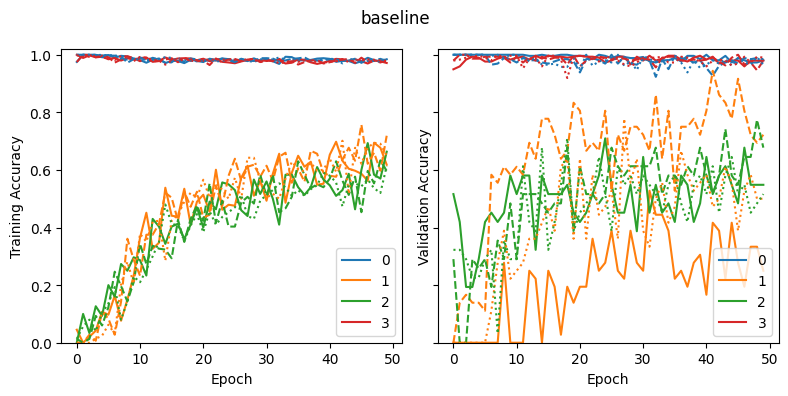

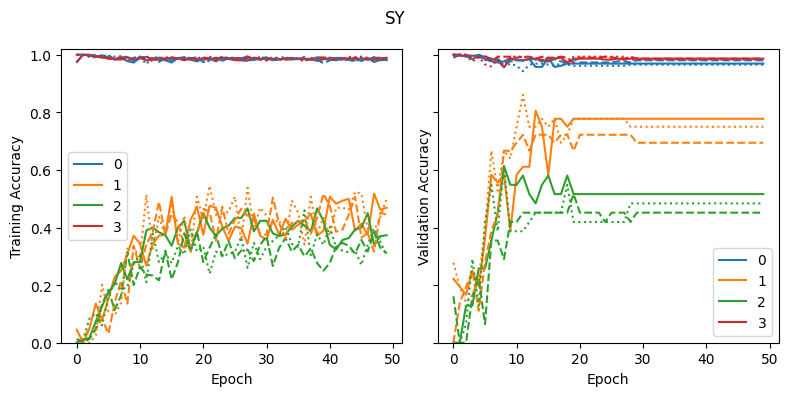

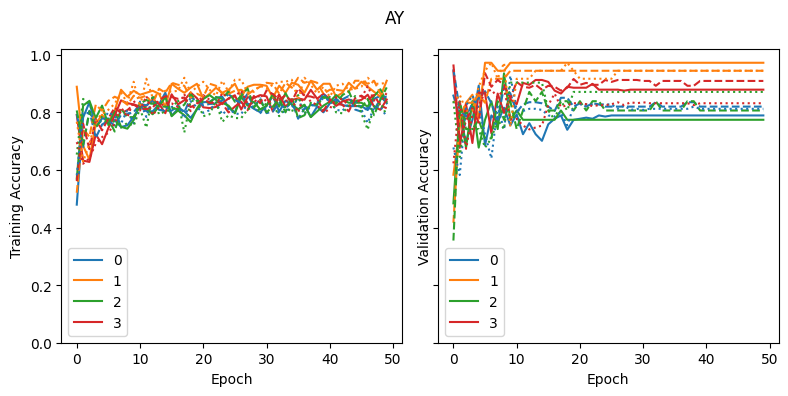

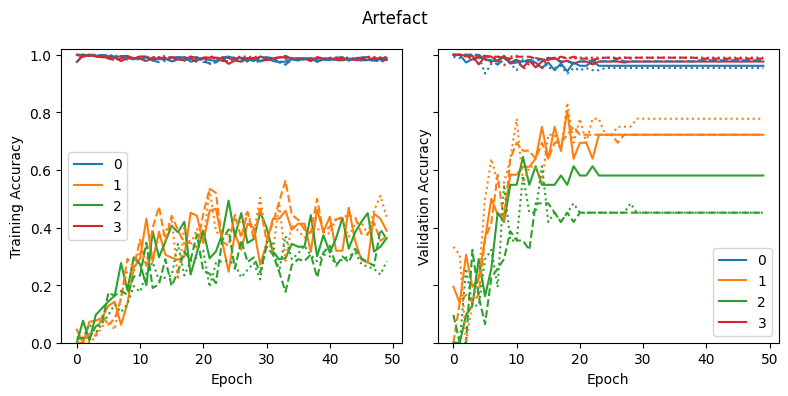

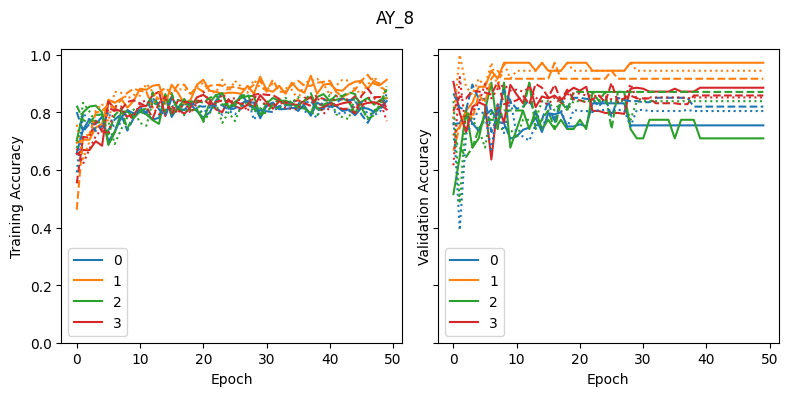

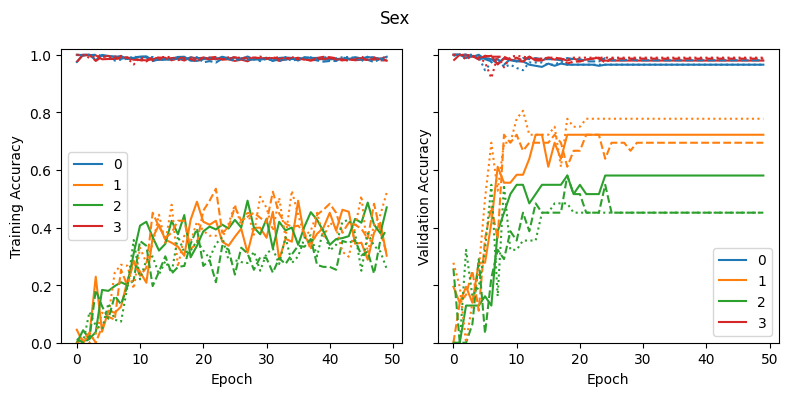

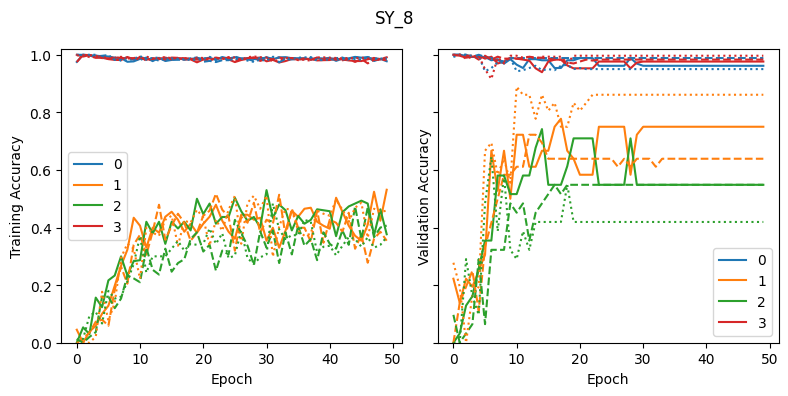

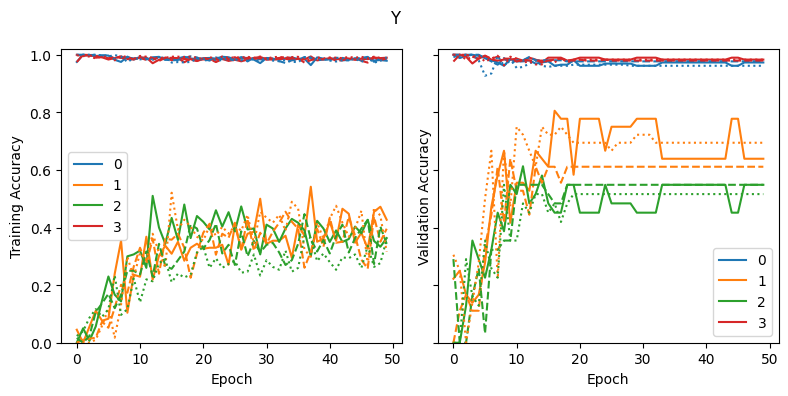

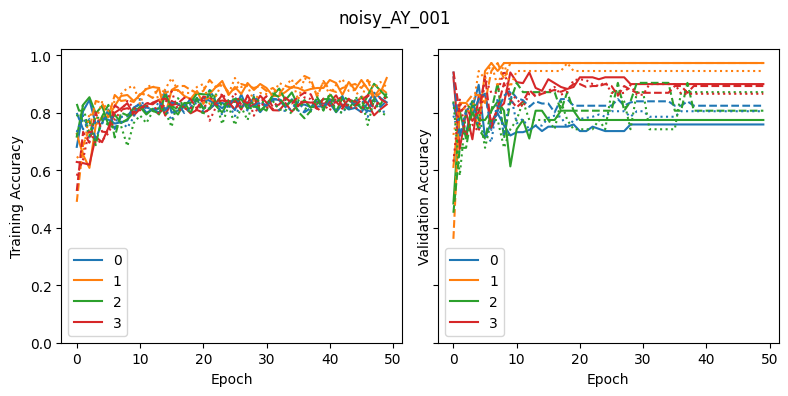

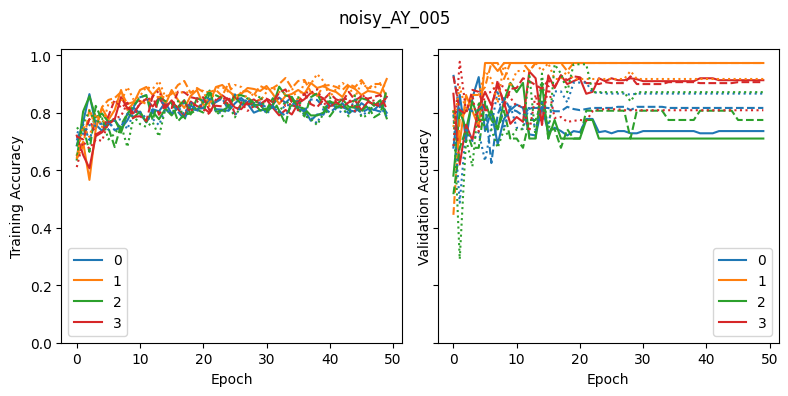

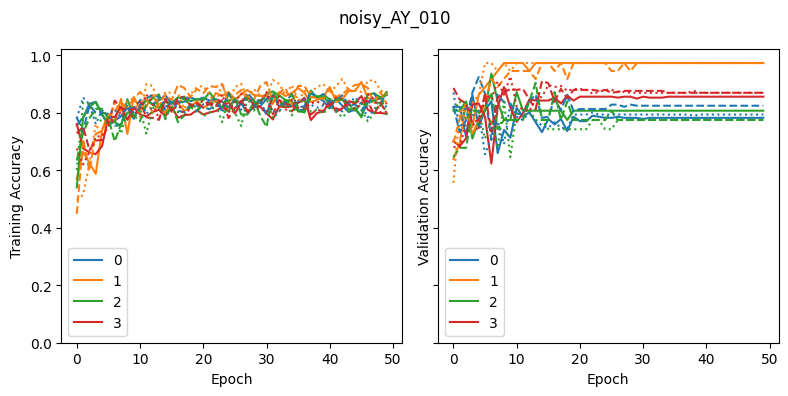

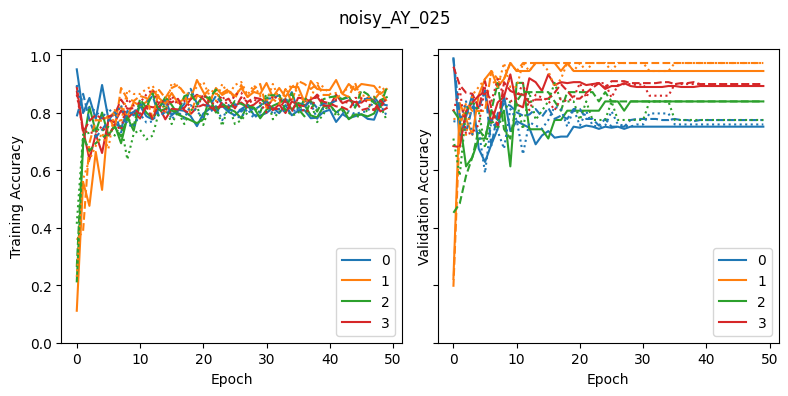

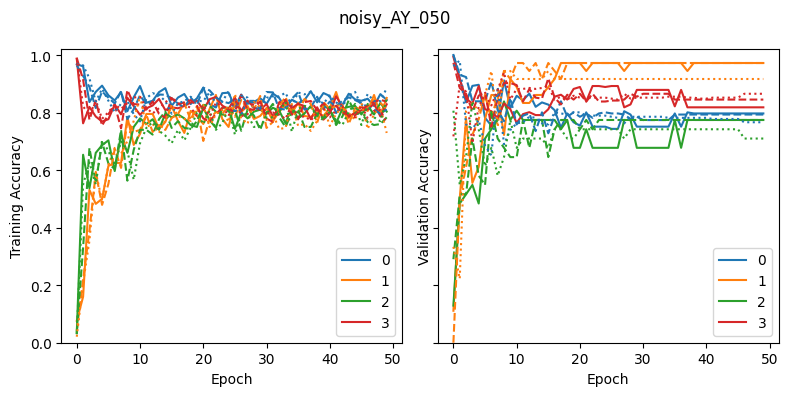

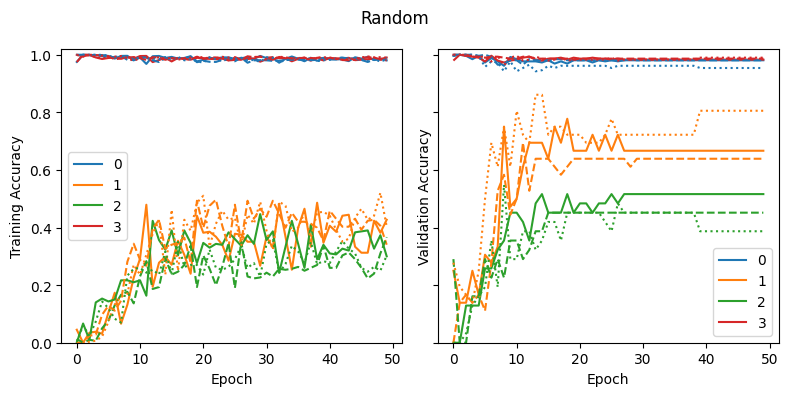

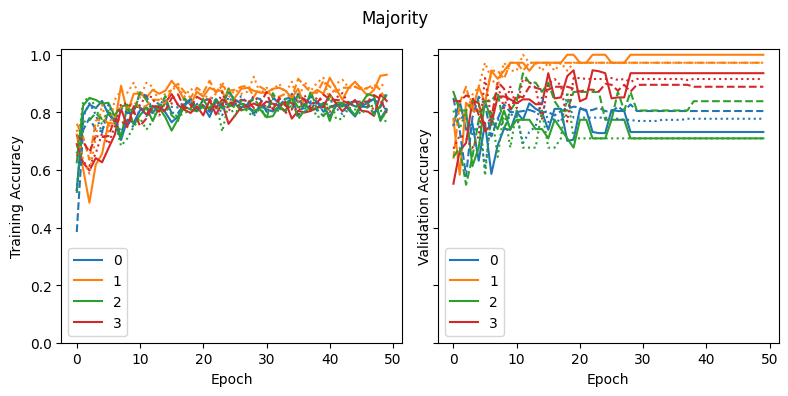

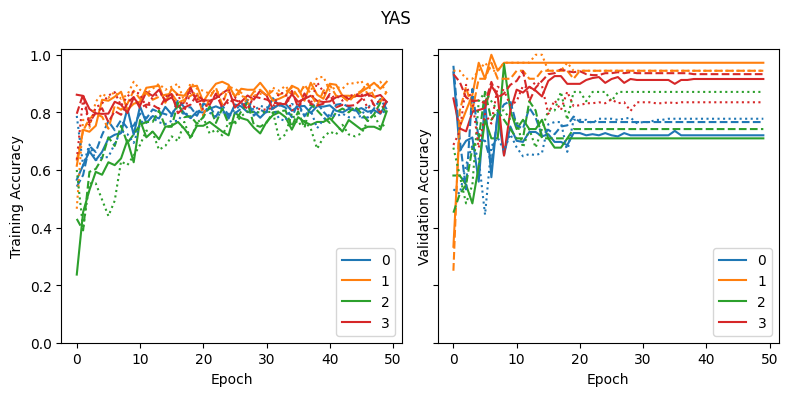

In [137]:
subgroup = 'AY' # or 'Sex'
experiments = test_results_dict.keys()
for experiment in experiments:
    train_preds_dict,val_preds_dict = train_val_dict[experiment],train_val_dict[experiment]
    plot_subgroup_acc(train_preds_dict,val_preds_dict, subgroup,plot_gap=False,plot_auc=False,plot_all=True,title = experiment,multiple_random_seeds=True)


## gDRO losses

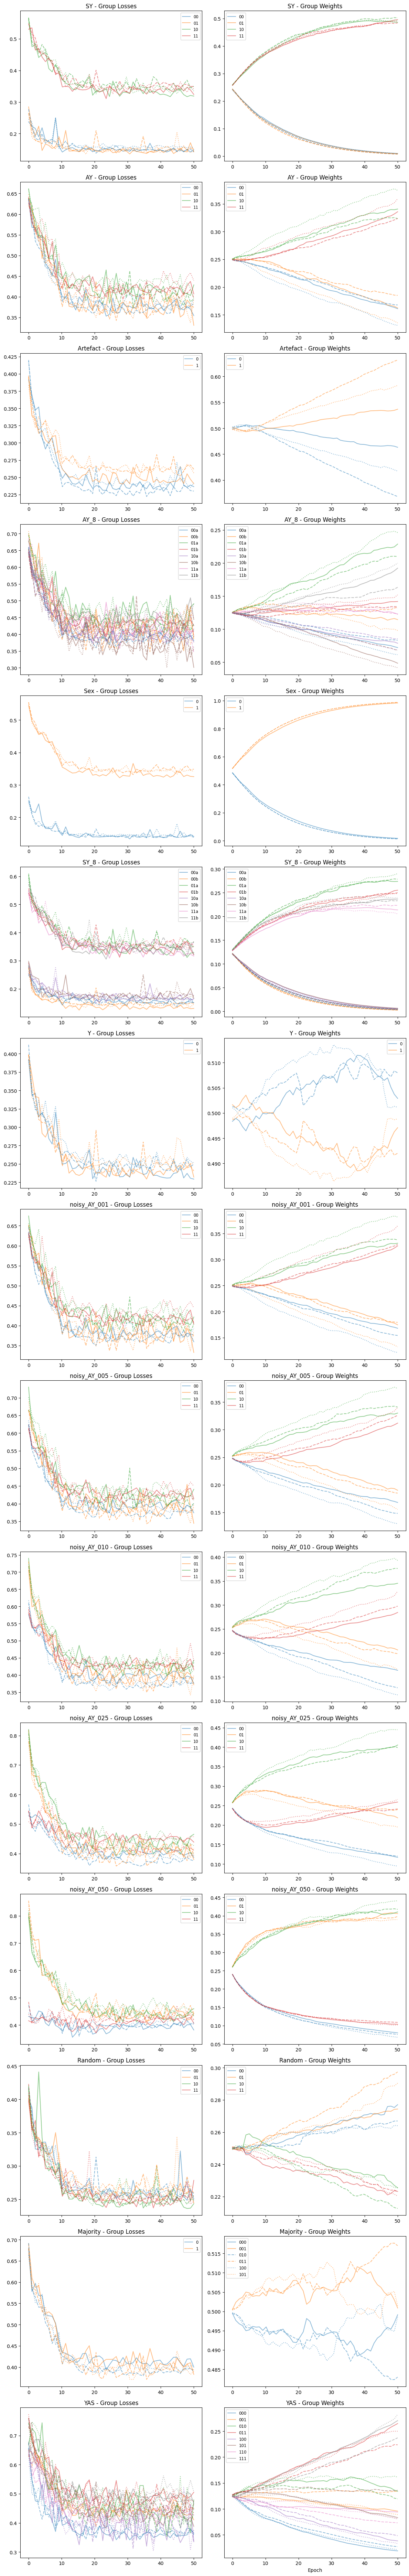

In [138]:
linestyles = ['-', '--', ':', '-.', ':']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

n_rows = len(loss_dict.keys())
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 5 * n_rows))

for row, experiment in enumerate(loss_dict.keys()):
    for i, random_seed in enumerate(loss_dict[experiment].keys()):
        mean_losses = loss_dict[experiment][random_seed]['mean_losses']
        dro_losses = loss_dict[experiment][random_seed]['losses']
        group_losses = loss_dict[experiment][random_seed]['group_losses']
        weights = loss_dict[experiment][random_seed]['weights']

        x = np.linspace(0, len(mean_losses), len(mean_losses))

        # Plot group losses
        ax1 = axes[row, 0]
        ax1.set_prop_cycle(color=colors)
        ax1.plot(x,group_losses,alpha = 0.5,linestyle=linestyles[i])
        plt.xlabel('Epoch')
        #plt.ylim(0.3,1)
        if len(group_losses[0]) == 4:
            ax1.legend(['00','01','10','11'],fontsize='small')
        if len(group_losses[0]) == 2:
            ax1.legend(['0','1'],fontsize='small')
        if len(group_losses[0]) == 8:
            if experiment == 'YAS':
                ax2.legend(['000','001','010','011','100','101','110','111'],fontsize='small')
            else:
                ax1.legend(['00a','00b','01a','01b','10a','10b','11a','11b'],fontsize='small')

        # Plot group losses
        ax2 = axes[row, 1]
        ax2.set_prop_cycle(color=colors)
        ax2.plot(x,weights,alpha = 0.5,linestyle=linestyles[i])
        plt.xlabel('Epoch')
        #plt.ylim(0.3,1)
        if len(group_losses[0]) == 4:
            ax2.legend(['00','01','10','11'],fontsize='small')
        if len(group_losses[0]) == 2:
            ax2.legend(['0','1'],fontsize='small')
        if len(group_losses[0]) == 8:
            if experiment == 'YAS':
                ax2.legend(['000','001','010','011','100','101','110','111'],fontsize='small')
            else:
                ax2.legend(['00a','00b','01a','01b','10a','10b','11a','11b'],fontsize='small')
       
    axes[row, 0].set_title(f'{experiment} - Group Losses')
    axes[row, 1].set_title(f'{experiment} - Group Weights')

plt.tight_layout()
plt.show()

# Specific investigation on noise

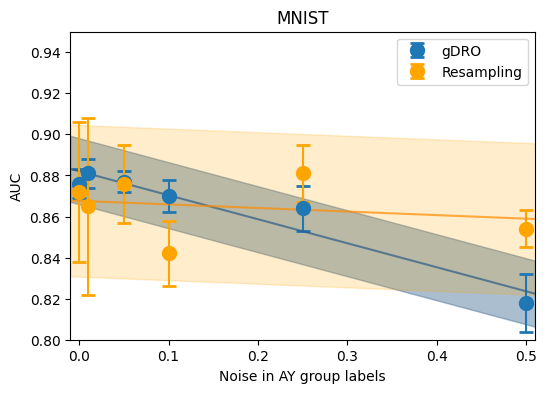

In [ ]:
# gDRO
noise_overall_test_results = overall_results_df.loc[['AY','noisy_AY_001','noisy_AY_005','noisy_AY_010','noisy_AY_025','noisy_AY_050']]
noise_overall_std_test_results = overall_std_df.loc[['AY','noisy_AY_001','noisy_AY_005','noisy_AY_010','noisy_AY_025','noisy_AY_050']]

# rename index
noise_overall_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_std_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_test_results.index.name = 'Noise in AY groups'

x1 = noise_overall_test_results.index.values
y1 = noise_overall_test_results['AUC']
yerr1 = noise_overall_std_test_results['AUC']
plt.figure(figsize=(6, 4))
plt.errorbar(
    x1, y1, yerr=yerr1,
    fmt='o', markersize=10, capsize=5, capthick=2, label='gDRO'
)

slope1, intercept1, _, _, std_err1 = linregress(x1, y1)
line_x1 = np.linspace(min(x1)-0.01, max(x1)+0.01, 100)
line_y1 = slope1 * line_x1 + intercept1
stderr_fit1 = std_err1 * 1  # Adjusted CI margin
line_y_lower1 = line_y1 - stderr_fit1
line_y_upper1 = line_y1 + stderr_fit1

plt.plot(line_x1, line_y1, color='#2b5d87', alpha=0.7)
plt.fill_between(line_x1, line_y_lower1, line_y_upper1, alpha=0.4, color='#2b5d87')

# RESAMPLING
noise_overall_test_results = resampling_overall_results_df.loc[['AY','noisy_AY_001','noisy_AY_005','noisy_AY_010','noisy_AY_025','noisy_AY_050']]
noise_overall_std_test_results = resampling_overall_std_df.loc[['AY','noisy_AY_001','noisy_AY_005','noisy_AY_010','noisy_AY_025','noisy_AY_050']]

# rename index
noise_overall_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_std_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_test_results.index.name = 'Noise in AY groups'

x2 = noise_overall_test_results.index.values
y2 = noise_overall_test_results['AUC']
yerr2 = noise_overall_std_test_results['AUC']

plt.errorbar(
    x2, y2, yerr=yerr2,
    fmt='o', markersize=10, capsize=5, capthick=2, label='Resampling', color='orange'
)

slope2, intercept2, _, _, std_err2 = linregress(x2, y2)
line_x2 = np.linspace(min(x2)-0.01, max(x2)+0.01, 100)
line_y2 = slope2 * line_x2 + intercept2
stderr_fit2 = std_err2 * 1  # Adjusted CI margin
line_y_lower2 = line_y2 - stderr_fit2
line_y_upper2 = line_y2 + stderr_fit2

plt.plot(line_x2, line_y2, color='darkorange', alpha=0.7)
plt.fill_between(line_x2, line_y_lower2, line_y_upper2, alpha=0.2, color='orange')

plt.xlabel('Noise in AY group labels')
plt.ylabel('AUC')
plt.xlim(-0.01, 0.51)
plt.ylim(0.8, 0.95)
plt.legend()
plt.title('MNIST')
plt.show()


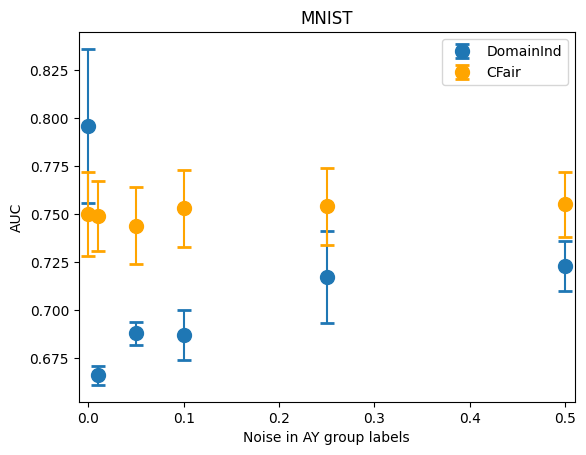

In [ ]:
# DomainInd
noise_overall_test_results = DomainInd_overall_results_df.loc[['Artefact','noisy_A_001','noisy_A_005','noisy_A_010','noisy_A_025','noisy_A_050']]
noise_overall_std_test_results = DomainInd_overall_std_df.loc[['Artefact','noisy_A_001','noisy_A_005','noisy_A_010','noisy_A_025','noisy_A_050']]

# rename index
noise_overall_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_std_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_test_results.index.name = 'Noise in AY groups'

x1 = noise_overall_test_results.index.values
y1 = noise_overall_test_results['AUC']
yerr1 = noise_overall_std_test_results['AUC']

plt.errorbar(
    x1, y1, yerr=yerr1,
    fmt='o', markersize=10, capsize=5, capthick=2, label='DomainInd'
)

slope1, intercept1, _, _, std_err1 = linregress(x1, y1)
line_x1 = np.linspace(min(x1)-0.01, max(x1)+0.01, 100)
line_y1 = slope1 * line_x1 + intercept1
stderr_fit1 = std_err1 * 1  # Adjusted CI margin
line_y_lower1 = line_y1 - stderr_fit1
line_y_upper1 = line_y1 + stderr_fit1

# CFair
noise_overall_test_results = cfair_overall_results_df.loc[['Artefact','noisy_A_001','noisy_A_005','noisy_A_010','noisy_A_025','noisy_A_050']]
noise_overall_std_test_results = cfair_overall_std_df.loc[['Artefact','noisy_A_001','noisy_A_005','noisy_A_010','noisy_A_025','noisy_A_050']]

# rename index
noise_overall_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_std_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_test_results.index.name = 'Noise in AY groups'

x2 = noise_overall_test_results.index.values
y2 = noise_overall_test_results['AUC']
yerr2 = noise_overall_std_test_results['AUC']

plt.errorbar(
    x2, y2, yerr=yerr2,
    fmt='o', markersize=10, capsize=5, capthick=2, label='CFair', color='orange'
)

slope2, intercept2, _, _, std_err2 = linregress(x2, y2)
line_x2 = np.linspace(min(x2)-0.01, max(x2)+0.01, 100)
line_y2 = slope2 * line_x2 + intercept2
stderr_fit2 = std_err2 * 1  # Adjusted CI margin
line_y_lower2 = line_y2 - stderr_fit2
line_y_upper2 = line_y2 + stderr_fit2

# Customize the plot
plt.xlabel('Noise in AY group labels')
plt.ylabel('AUC')
plt.xlim(-0.01, 0.51)
plt.legend()
plt.title('MNIST')
plt.show()


# Correlate performance with distance from P_test

In [141]:
subgroups_calculated = ['SY','AY','Artefact','AY_8','Sex','SY_8','Y','Random','Majority','YAS','noisy_AY_001','noisy_AY_005','noisy_AY_010','noisy_AY_025','noisy_AY_050'] # coudl add baseline with 0.38
P_test_distance_gdro = [0.375,0.129,0.295,0.129,0.375,0.375,0.295,0.375,0.17,0,0.129,0.13,0.131,0.135,0.141]
P_test_distance_resampling = [0.375,0.129,0.375,0.129,0.375,0.375,0.375,0.375,0.17,0,0.129,0.13,0.161,0.210,0.289] # p_test distance is slightly different for resampling

p_test_distance_gdro_df = pd.DataFrame(P_test_distance_gdro,index=subgroups_calculated,columns=['P_test_distance'])
p_test_distance_resampling_df = pd.DataFrame(P_test_distance_resampling,index=subgroups_calculated,columns=['P_test_distance'])

resampling_results_p_test = pd.merge(resampling_overall_results_df,p_test_distance_resampling_df,left_index=True,right_index=True)
resampling_results_p_test['AUC std'] = resampling_overall_std_df['AUC']
resampling_results_p_test['Accuracy std'] = resampling_overall_std_df['Accuracy']

gdro_results_p_test = pd.merge(overall_results_df,p_test_distance_gdro_df,left_index=True,right_index=True)
gdro_results_p_test['AUC std'] = overall_std_df['AUC']
gdro_results_p_test['Accuracy std'] = overall_std_df['Accuracy']

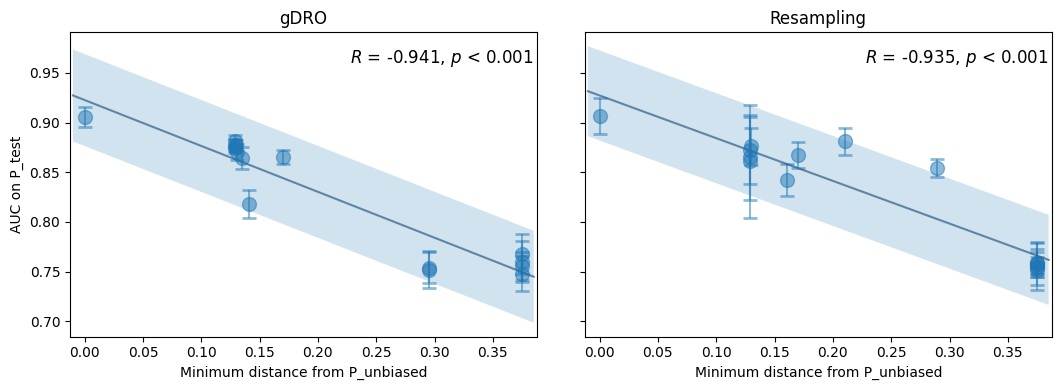

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

axes[0].errorbar(
    gdro_results_p_test['P_test_distance'],
    gdro_results_p_test['AUC'],
    yerr=gdro_results_p_test['AUC std'],
    fmt='o',
    markersize=10,
    capsize=5,
    capthick=2,
    alpha=0.5
)
slope, intercept, r_value, p_value, std_err = linregress(gdro_results_p_test['P_test_distance'], gdro_results_p_test['AUC'])
line_x = np.linspace(min(gdro_results_p_test['P_test_distance'])-0.01, max(gdro_results_p_test['P_test_distance'])+0.01, 100)
line_y = slope * line_x + intercept
stderr_fit = gdro_results_p_test['AUC std'].std()  # Approximation for confidence interval width
line_y_lower = line_y - std_err
line_y_upper = line_y + std_err
axes[0].plot(line_x, line_y, label='Best fit line', color='#2b5d87', alpha=0.7)
axes[0].fill_between(line_x, line_y_lower, line_y_upper, alpha=0.2, label='95% CI')

# Compute and add Pearson correlation coefficient (ρ)
if p_value < 0.001:
    axes[0].text(0.6, 0.9, f"$R$ = {r_value:.3f}, $p$ < {0.001}", transform=axes[0].transAxes, fontsize=12) 


axes[0].set_title("gDRO")
axes[0].set_xlabel("Minimum distance from P_unbiased")
axes[0].set_ylabel("AUC on P_test")
axes[0].set_xlim(-0.0125, 0.3875)

axes[1].errorbar(
    resampling_results_p_test['P_test_distance'],
    resampling_results_p_test['AUC'],
    yerr=resampling_results_p_test['AUC std'],
    fmt='o',
    markersize=10,
    capsize=5,
    capthick=2,
    alpha=0.5
)
slope, intercept, r_value, p_value, std_err = linregress(resampling_results_p_test['P_test_distance'], resampling_results_p_test['AUC'])
line_x = np.linspace(min(resampling_results_p_test['P_test_distance'])-0.01, max(resampling_results_p_test['P_test_distance'])+0.01, 100)
line_y = slope * line_x + intercept
stderr_fit = resampling_results_p_test['AUC std'].std()  # Approximation for confidence interval width
line_y_lower = line_y - std_err
line_y_upper = line_y + std_err
axes[1].plot(line_x, line_y, label='Best fit line', color='#2b5d87', alpha=0.7)
axes[1].fill_between(line_x, line_y_lower, line_y_upper, alpha=0.2, label='95% CI')

# Compute and add Pearson correlation coefficient (ρ)
if p_value < 0.001:
    axes[1].text(0.6, 0.9, f"$R$ = {r_value:.3f}, $p$ < {0.001}", transform=axes[1].transAxes, fontsize=12) 

axes[1].set_title("Resampling")
axes[1].set_xlabel("Minimum distance from P_unbiased")
axes[1].set_xlim(-0.0125, 0.3875)
plt.tight_layout()
plt.show()
